# Cell Migration Simulation - Workflow

This notebook demonstrates the complete workflow for simulating cell migration in a stadium-shaped domain with chemotactic gradient.

## 1. Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from simulation import Simulation
from scipy.stats import lognorm
from analysis import (calculate_autocorrelation, calculate_msd,
                      fit_von_mises_mixture_mle, compute_turning_angles,
                      compute_msd_dacf_per_movie)
from visualization import plot_trajectories, create_animation, plot_cell_statistics

## 2. Load and Analyze Experimental Data

Load experimental trajectory data and fit velocity and turning angle distributions.

In [18]:
# Load experimental data
data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2025_01_22_2DFACS_FOXA2positive_lateday2.csv')

# Calculate velocities if not already present
data['v_x'] = data.groupby('track_id')['x_microns'].diff()
data['v_y'] = data.groupby('track_id')['y_microns'].diff()
data['speed_micron_per_minutes'] = np.sqrt(data['v_x']**2 + data['v_y']**2) / data.groupby('track_id')['t'].diff()

In [19]:
# Fit log-normal distribution to velocities
velocities = data['speed_micron_per_minutes'].dropna()
velocities = velocities[velocities > 0]
shape, loc, scale = lognorm.fit(velocities, floc=0)
velocity_params = {'shape': shape, 'loc': loc, 'scale': scale}

print(f"Velocity distribution parameters: shape={shape:.3f}, loc={loc:.3f}, scale={scale:.3f}")

Velocity distribution parameters: shape=0.885, loc=0.000, scale=0.183


In [20]:
# Compute and fit turning angles distribution
turning_angles = compute_turning_angles(data, track_col='track_id',
                                       x_col='x_microns', y_col='y_microns',
                                       step_col='step', lag=1)

# Fit von Mises mixture model
vonmises_fit = fit_von_mises_mixture_mle(turning_angles, initial_guess=(0.5, 1.0, 5.0))
vonmises_params = vonmises_fit['params']

print(f"Von Mises parameters: W1={vonmises_params['W1']:.3f}, "
      f"kappa1={vonmises_params['kappa1']:.3f}, kappa2={vonmises_params['kappa2']:.3f}")

Von Mises parameters: W1=0.647, kappa1=0.726, kappa2=5.448


In [21]:
# Compute experimental MSD and DACF
msd_exp, dacf_exp = compute_msd_dacf_per_movie(data, x_col='x_microns',
                                                y_col='y_microns', max_lag=None)

## 3. Run Simulation

Create and run a simulation with fitted parameters.

In [34]:
# Create simulation with fitted parameters
sim = Simulation(
    n_cells=50,
    time_step=5.0,              # minutes
    stadium_L=800,              # microns
    stadium_R=200,              # microns
    source_length=400,          # microns
    chemotaxis_strength=0.0,    # adjust as needed
    repulsion_strength=0.0,     # adjust as needed
    interaction_radius=0.0,
    velocity_params=velocity_params,
    persistence=0.8,            # adjust as needed
    starting_positions='perimeter',
    mode='power_memory',          # options: 'random', 'persistent', 'biased_persistent', 'exp_memory', 'uniform_memory', 'power_memory'
    memory_window=10,
    memory_exp_lambda=0.1,
    memory_power_alpha=1.5,
    vonmises_params=vonmises_params
)

# Run simulation
sim.run(n_steps=data.step.max(), verbose=True)

Step 25/240 completed
Step 50/240 completed
Step 75/240 completed
Step 100/240 completed
Step 125/240 completed
Step 150/240 completed
Step 175/240 completed
Step 200/240 completed
Step 225/240 completed
Simulation completed: 240 steps


## 4. Visualize Results

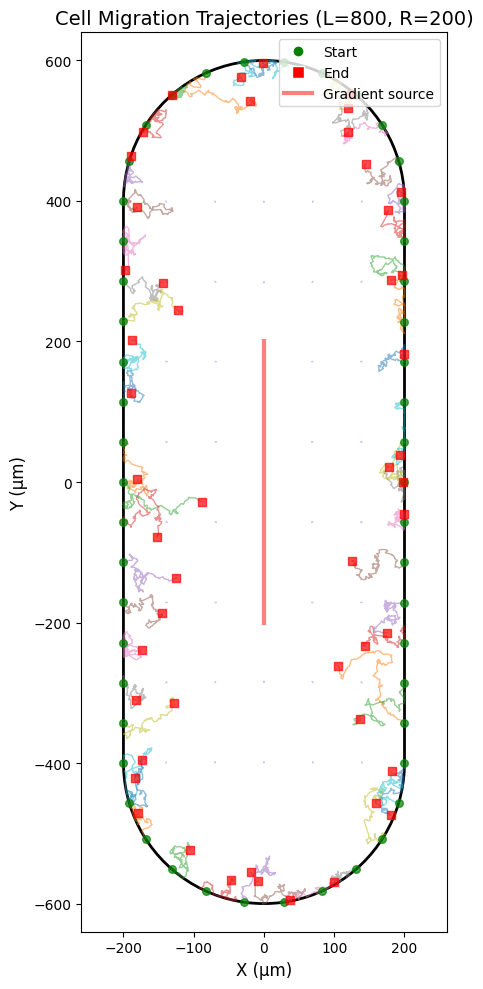

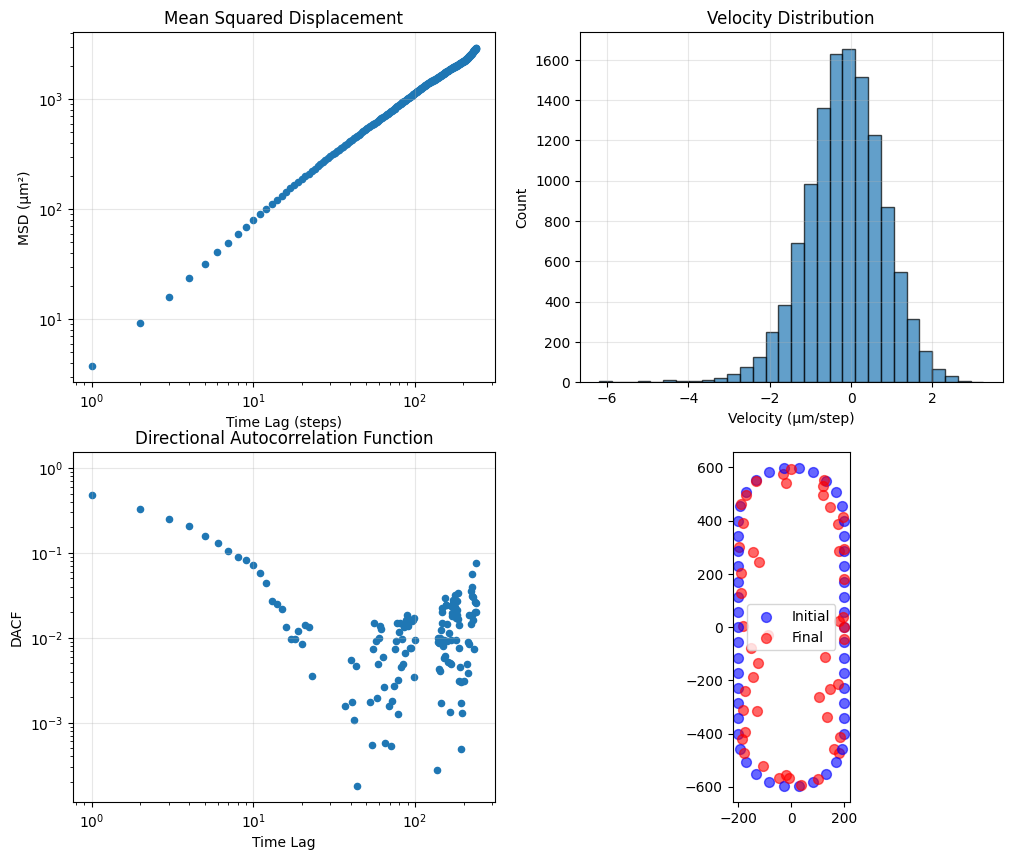

In [35]:
# Plot trajectories
plot_trajectories(sim, show_gradient=True)

# Plot statistics
plot_cell_statistics(sim)

# Create animation (optional)
# create_animation(sim, interval=100, save_path='migration.gif')

## 5. Compare with Experimental Data

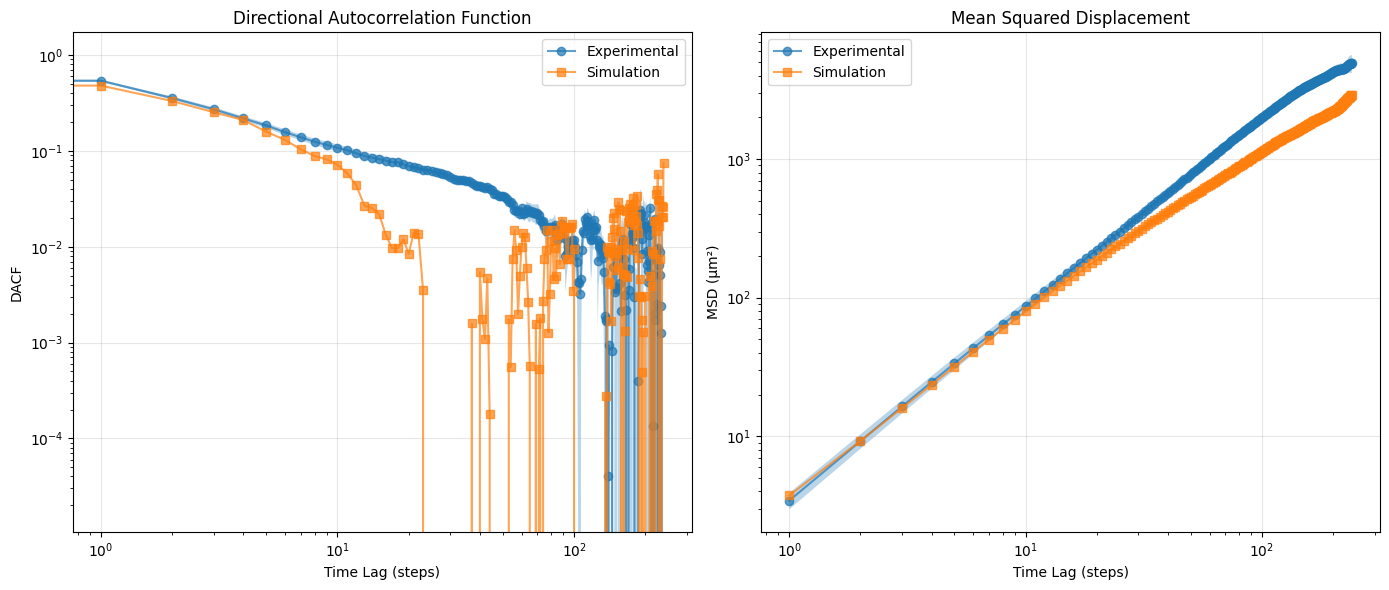

In [36]:
# Get simulation data
sim_df = sim.get_dataframe()

# Calculate simulation metrics
sim_dacf = calculate_autocorrelation(sim_df, max_lag=None, directional=True)
sim_msd = calculate_msd(sim_df, max_lag=None)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# DACF comparison
ax1.plot(dacf_exp['lag'], dacf_exp['dacf_mean'], 'o-', label='Experimental', alpha=0.7)
ax1.fill_between(dacf_exp['lag'],
                  dacf_exp['dacf_mean'] - dacf_exp['dacf_sem'],
                  dacf_exp['dacf_mean'] + dacf_exp['dacf_sem'], alpha=0.3)
ax1.plot(sim_dacf['lag'], sim_dacf['dacf'], 's-', label='Simulation', alpha=0.7)
ax1.set_xlabel('Time Lag (steps)')
ax1.set_ylabel('DACF')
ax1.set_title('Directional Autocorrelation Function')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MSD comparison
ax2.plot(msd_exp['lag'], msd_exp['msd_mean'], 'o-', label='Experimental', alpha=0.7)
ax2.fill_between(msd_exp['lag'],
                  msd_exp['msd_mean'] - msd_exp['msd_sem'],
                  msd_exp['msd_mean'] + msd_exp['msd_sem'], alpha=0.3)
ax2.plot(sim_msd['lag'], sim_msd['msd'], 's-', label='Simulation', alpha=0.7)
ax2.set_xlabel('Time Lag (steps)')
ax2.set_ylabel('MSD (μm²)')
ax2.set_title('Mean Squared Displacement')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Parameter Fitting (Optional)

Perform grid search to find best-fit parameters.

In [25]:
# Uncomment to run parameter fitting
# from fit import fit_grid

# param_grid = {
#     'persistence': [0.0, 0.3, 0.5, 0.7, 0.9],
#     'chemotaxis_strength': [0.0, 0.1, 0.3, 0.5],
#     'memory_exp_lambda': [0.05, 0.1, 0.2]
# }

# best_params, results_table = fit_grid(
#     exp_df=data,
#     simulation_mode='exp_memory',
#     param_grid=param_grid,
#     chi_weight=0.5,
#     velocity_dist_params=velocity_params,
#     vonmises_params=vonmises_params,
#     n_steps=100,
#     n_cells=50,
#     seed=42
# )

# print("Best parameters:")
# print(best_params)
# results_table.to_csv('fitting_results.csv', index=False)

## 7. Save Results

In [26]:
# from datetime import datetime

# def _fmt_val(v):
#     if v is None:
#         return "None"
#     # numpy types etc.
#     try:
#         if float(v).is_integer():
#             s = f"{int(float(v))}"
#         else:
#             s = f"{float(v):g}"
#     except Exception:
#         s = str(v)
#     # make filename-safe: replace dot and minus
#     s = s.replace(".", "p").replace("-", "m").replace(" ", "")
#     return s

# # timestamp + simulation mode
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# mode = getattr(sim, "mode", getattr(sim, "simulation_mode", "sim"))

# # pick common simulation parameters to include if present
# _param_names = [
#     "n_cells", "time_step", "stadium_L", "stadium_R", "source_length",
#     "chemotaxis_strength", "repulsion_strength", "interaction_radius",
#     "persistence", "memory_window", "memory_exp_lambda", "seed"
# ]

# parts = []
# for pn in _param_names:
#     if hasattr(sim, pn):
#         parts.append(f"{pn[:4]}{_fmt_val(getattr(sim, pn))}")

# params_str = "_".join(parts)
# base = f"{timestamp}_{mode}"
# if params_str:
#     base = f"{base}_{params_str}"

# # Compose filenames
# traj_fname = f"simulation_{base}_trajectories.csv"
# dacf_fname = f"simulation_{base}_dacf.csv"
# msd_fname = f"simulation_{base}_msd.csv"

# # Save
# sim.save_trajectories(traj_fname)
# sim_dacf.to_csv(dacf_fname, index=False)
# sim_msd.to_csv(msd_fname, index=False)

# print(f"Results saved:\n - {traj_fname}\n - {dacf_fname}\n - {msd_fname}")